In [13]:
import sys
import os
import dotenv

from IPython.utils import io

import eolearn
from eolearn.core import (
    FeatureType,
    linearly_connect_tasks,
    EOWorkflow,
    OutputTask,
    LoadTask
)
from eolearn.ml_tools import TrainTestSplitTask

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from lightgbm import log_evaluation, early_stopping
import optuna.integration.lightgbm as lgb
from sklearn.metrics import mean_squared_error
import dalex as dx

root_dir = os.path.abspath('../')
if not root_dir in sys.path: sys.path.append(root_dir)

import eolearn_extras as eolx
from sdb_utils.ml_utils import (
    get_X_y_for_split,
    SplitType,
    create_sdb_estimation,
    get_masked_map,
    create_train_val_set,
    write_optuna_capture_to_logs,
)

dotenv.load_dotenv()
data_root_path = os.environ.get('data_root')

In [14]:
bahamas_eop_path = os.path.abspath(
    os.path.join(data_root_path, 'eopatches', 'mille_lacs_sentinel_merged')
)
load_bahamas_eop = LoadTask(bahamas_eop_path)

data_mask_feature = (FeatureType.MASK_TIMELESS, 'buffered_bathy_mask')
train_test_mask_feature = (FeatureType.MASK_TIMELESS, 'train_test_split')

train_test_split_task = TrainTestSplitTask(
    input_feature=data_mask_feature,
    output_feature=train_test_mask_feature,
    bins=[0.025, 0.05],
    split_type=eolearn.ml_tools.train_test_split.TrainTestSplitType.PER_PIXEL,
)

valid_train_test_data_mask_task = eolx.ml_util.AddValidTrainTestMasks(
    train_test_maks_feature=train_test_mask_feature,
    valid_data_mask_feature=data_mask_feature
)

tt_wf_output_label = 'tt_wf_output'
output_task = OutputTask(tt_wf_output_label)

nodes = linearly_connect_tasks(
    load_bahamas_eop,
    train_test_split_task,
    valid_train_test_data_mask_task,
    output_task
)

read_merge_wf = EOWorkflow(nodes)

train_test_split_ref = [node for node in nodes if node.name == 'TrainTestSplitTask'][0]
read_merge_wf_res = read_merge_wf.execute(
    input_kwargs={
        train_test_split_ref: {'seed': 42}
    }
)

train_test_eop = read_merge_wf_res.outputs[tt_wf_output_label]
train_test_eop

EOPatch(
  data={
    L1C_data: numpy.ndarray(shape=(1, 2871, 2794, 13), dtype=uint16)
    L2A_data: numpy.ndarray(shape=(1, 2871, 2794, 12), dtype=float32)
    L2R_data: numpy.ndarray(shape=(1, 2871, 2794, 11), dtype=float32)
  }
  data_timeless={
    bathy_data: numpy.ndarray(shape=(2871, 2794, 1), dtype=float32)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
    buffered_bathy_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
    test_split_valid: numpy.ndarray(shape=(2871, 2794, 1), dtype=int32)
    train_split_valid: numpy.ndarray(shape=(2871, 2794, 1), dtype=int32)
    train_test_split: numpy.ndarray(shape=(2871, 2794, 1), dtype=int64)
    validation_split_valid: numpy.ndarray(shape=(2871, 2794, 1), dtype=int32)
  }
  meta_info={
    test_count: 4880210
    test_perc: 0.9500677186137317
    train_count: 128468
    train_perc: 0.02500984582115706
    validation_count: 128019
    validation_perc: 0.0249224355651112
  }
  bbox=BBox

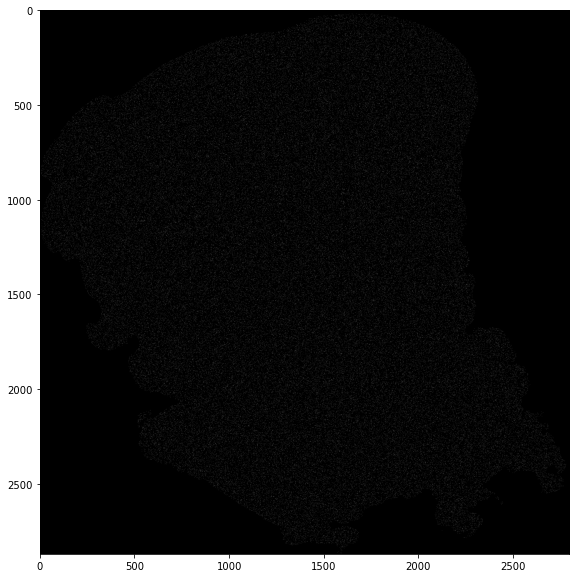

In [15]:
eolx.visualization.plot_single_band(train_test_eop, (FeatureType.MASK_TIMELESS, 'train_split_valid'), colorbar=False, stretch=False)
plt.show()

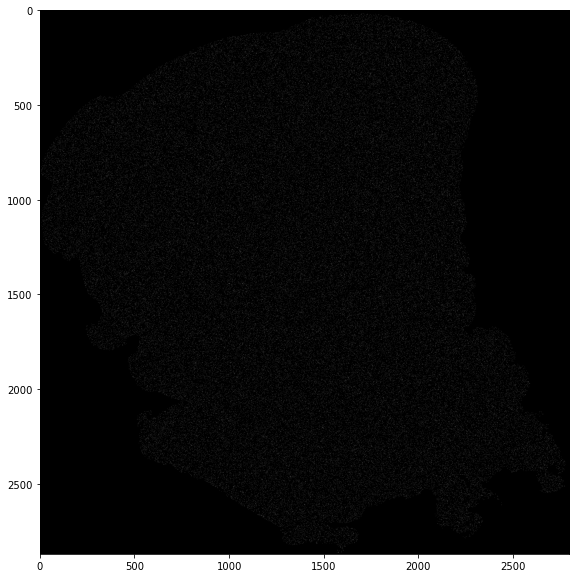

In [16]:
eolx.visualization.plot_single_band(train_test_eop, (FeatureType.MASK_TIMELESS, 'validation_split_valid'), colorbar=False, stretch=False)
plt.show()

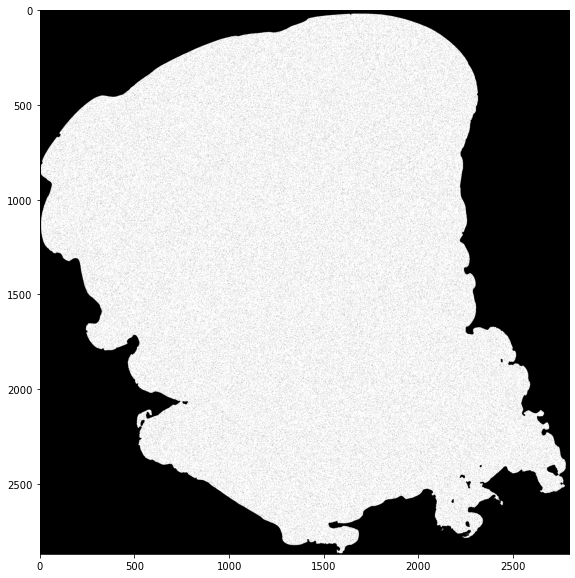

In [17]:
eolx.visualization.plot_single_band(train_test_eop, (FeatureType.MASK_TIMELESS, 'test_split_valid'), colorbar=False, stretch=False)
plt.show()

### L1C Testing

In [18]:
params = {
    'objective': 'regression',
    'metric': 'mean_squared_error',
    'seed': 42,
}

(train_ds, val_ds) = create_train_val_set(train_test_eop, (FeatureType.DATA, 'L1C_data'))

with io.capture_output() as capture:
    model_l1c = lgb.train(
        params,
        train_ds,
        valid_sets=val_ds,
        callbacks=[log_evaluation(100), early_stopping(100)],
        optuna_seed=42,
    )

write_optuna_capture_to_logs('../optuna_logs', capture)

[I 2022-05-04 13:12:36,712] A new study created in memory with name: no-name-67caa54b-2fe0-4db2-aa38-caa57d89fddf
[I 2022-05-04 13:12:39,947] Trial 0 finished with value: 19.748117547145906 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 19.748117547145906.
[I 2022-05-04 13:12:44,160] Trial 1 finished with value: 19.32602380651709 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 19.32602380651709.
[I 2022-05-04 13:12:49,079] Trial 2 finished with value: 19.32602380651709 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 19.32602380651709.
[I 2022-05-04 13:12:52,757] Trial 3 finished with value: 19.32602380651709 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 19.32602380651709.
[I 2022-05-04 13:12:56,841] Trial 4 finished with value: 19.32602380651709 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 19.32602380651709.
[I 2022-05-04 13:13:01,156] Trial 5 finished with value: 19

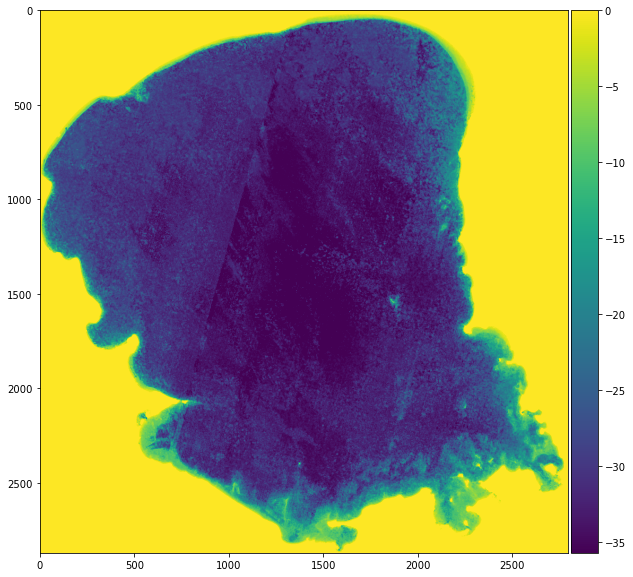

In [19]:
X_all, y_all = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.All,
    data_feature=(FeatureType.DATA, 'L1C_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
    data_mask_feature=data_mask_feature
)

l1c_sdb_estimation_values, l1c_sdb_estimation_map = create_sdb_estimation(
    train_test_eop,
    model_l1c,
    X_all,
    mask_feature=data_mask_feature
)
eolx.visualization.plot_ndarray_band(l1c_sdb_estimation_map, cmap='viridis')
plt.show()

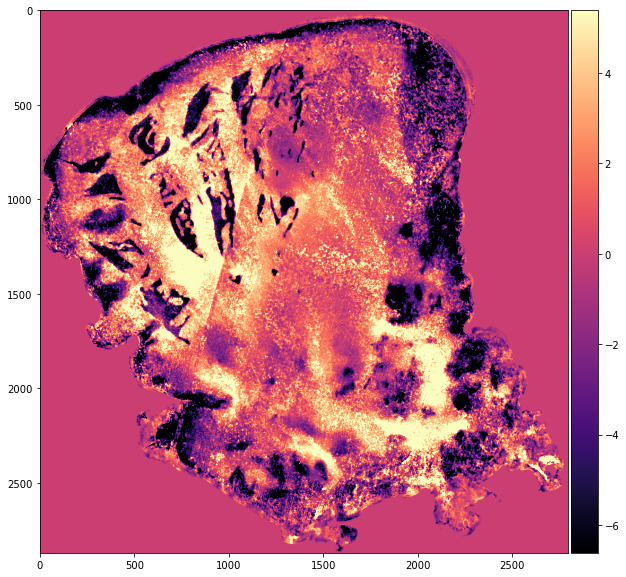

In [25]:
masked_bathy_data = get_masked_map(
    train_test_eop,
    (FeatureType.DATA_TIMELESS, 'bathy_data'),
    data_mask_feature
)
l1c_sdb_errors = l1c_sdb_estimation_map - masked_bathy_data
eolx.visualization.plot_ndarray_band(l1c_sdb_errors, cmap='magma')
plt.show()

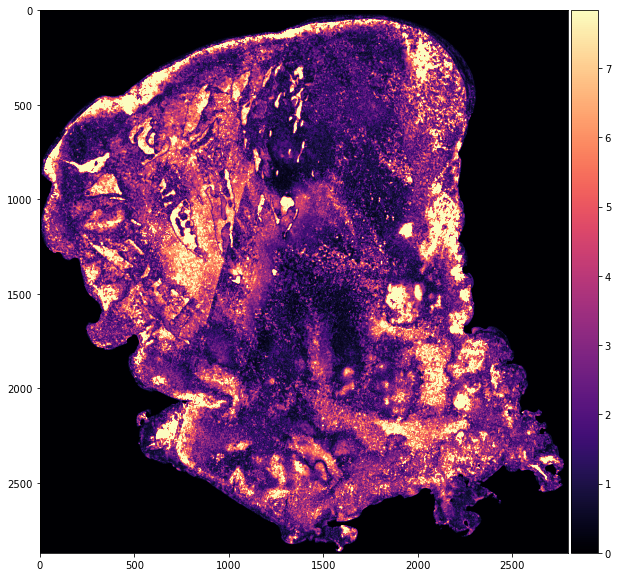

In [26]:
eolx.visualization.plot_ndarray_band(np.abs(l1c_sdb_errors), cmap='magma')
plt.show()

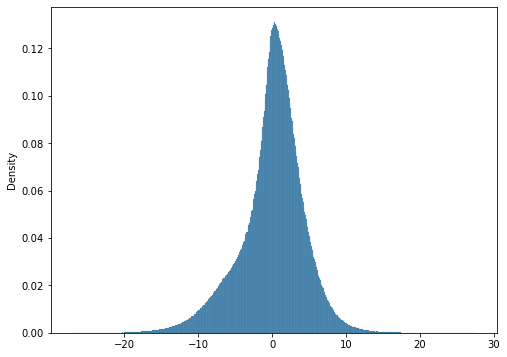

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))
l1c_sdb_residuals = l1c_sdb_estimation_values - y_all
sns.histplot(l1c_sdb_residuals, binwidth=0.1, stat='density', ax=ax)
plt.show()

In [28]:
exp_lgbm_l1c = dx.Explainer(model_l1c, val_ds.data, val_ds.label, label='lgbm_tuned_l1c', verbose=False)
exp_lgbm_l1c.model_performance()

### L2A Testing

In [29]:
(train_ds, val_ds) = create_train_val_set(train_test_eop, (FeatureType.DATA, 'L2A_data'))

with io.capture_output() as capture:
    model_l2a = lgb.train(
        params,
        train_ds,
        valid_sets=val_ds,
        callbacks=[log_evaluation(100), early_stopping],
        optuna_seed=42,
    )

write_optuna_capture_to_logs('../optuna_logs', capture)

[I 2022-05-04 13:23:10,138] A new study created in memory with name: no-name-ac7e6ee6-1bc8-43c6-88db-d2d6a37321f6
[I 2022-05-04 13:23:13,644] Trial 0 finished with value: 18.487602220519683 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 18.487602220519683.
[I 2022-05-04 13:23:16,807] Trial 1 finished with value: 18.681520646916482 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 18.487602220519683.
[I 2022-05-04 13:23:20,215] Trial 2 finished with value: 18.393304369729005 and parameters: {'feature_fraction': 0.8}. Best is trial 2 with value: 18.393304369729005.
[I 2022-05-04 13:23:23,511] Trial 3 finished with value: 18.540852397982437 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 18.393304369729005.
[I 2022-05-04 13:23:26,864] Trial 4 finished with value: 18.868418856936692 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 18.393304369729005.
[I 2022-05-04 13:23:30,561] Trial 5 finished with v

In [31]:
best_params = model_l2a.params
best_params

{'objective': 'regression',
 'metric': 'l2',
 'seed': 42,
 'feature_pre_filter': False,
 'lambda_l1': 6.205926454926931e-07,
 'lambda_l2': 6.584272062075244,
 'num_leaves': 64,
 'feature_fraction': 1.0,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20,
 'num_iterations': 1000,
 'early_stopping_round': None}

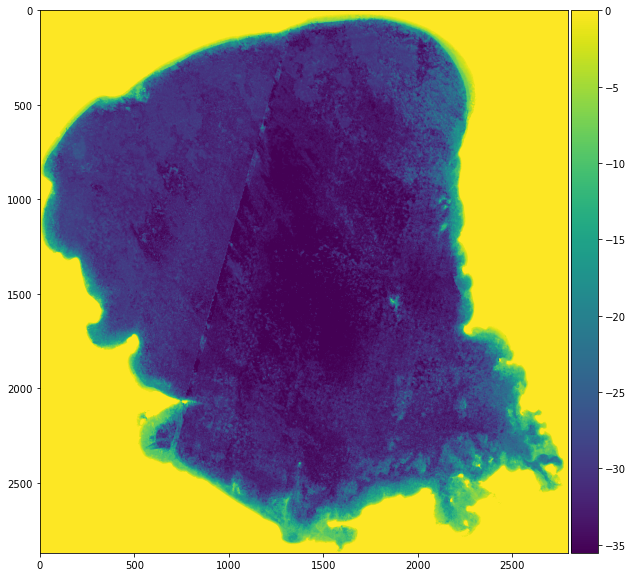

In [32]:
X_all, y_all = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.All,
    data_feature=(FeatureType.DATA, 'L2A_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
    data_mask_feature=data_mask_feature,
)

l2a_sdb_estimation_values, l2a_sdb_estimation_map = create_sdb_estimation(
    train_test_eop,
    model_l2a,
    X_all,
    data_mask_feature
)
eolx.visualization.plot_ndarray_band(l2a_sdb_estimation_map, cmap='viridis')
plt.show()

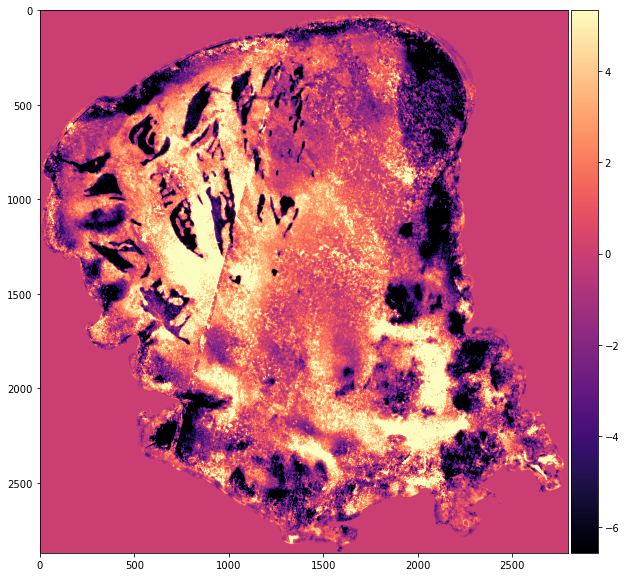

In [33]:
l2a_sdb_errors = l2a_sdb_estimation_map - masked_bathy_data
eolx.visualization.plot_ndarray_band(l2a_sdb_errors, cmap='magma')
plt.show()

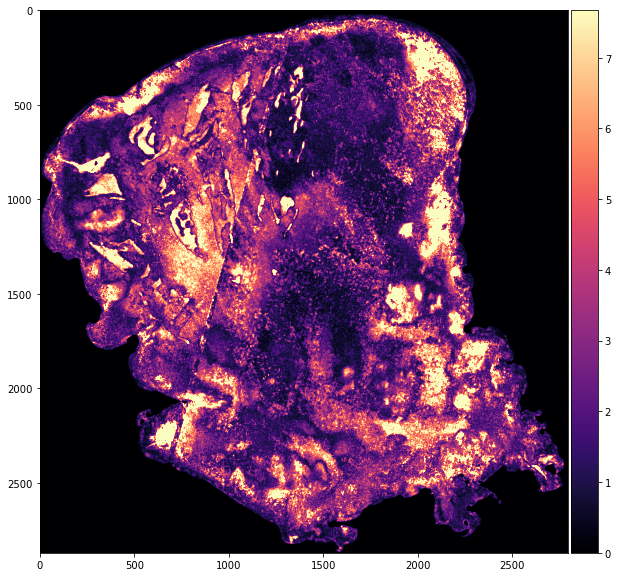

In [34]:
eolx.visualization.plot_ndarray_band(np.abs(l2a_sdb_errors), cmap='magma')
plt.show()

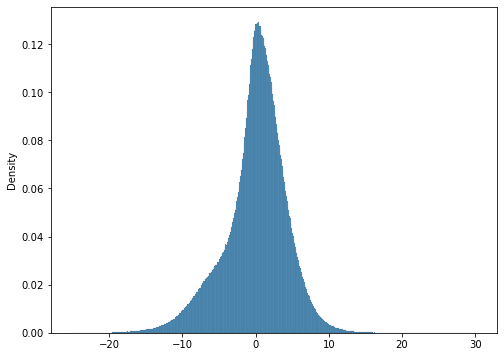

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))
l2a_sdb_residuals = l2a_sdb_estimation_values - y_all
sns.histplot(l2a_sdb_residuals, binwidth=0.1, stat='density', ax=ax)
plt.show()

In [36]:
exp_lgbm_l2a = dx.Explainer(model_l2a, val_ds.data, val_ds.label, label='lgbm_tuned_l2a', verbose=False)
exp_lgbm_l2a.model_performance()

### Evaluation

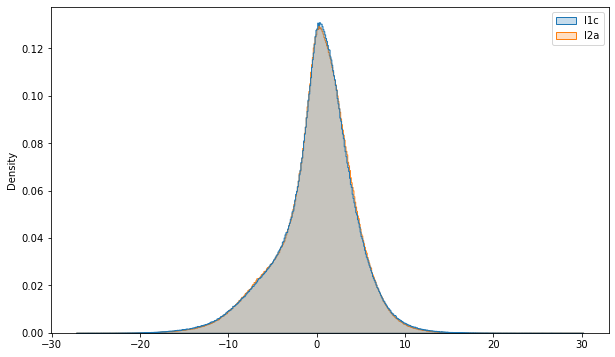

In [37]:
residuals_df = pd.DataFrame({
    'l1c': l1c_sdb_residuals,
    'l2a': l2a_sdb_residuals,
})

plt.figure(figsize=(10, 6))
sns.histplot(residuals_df, binwidth=0.1, stat='density', element='step', common_norm=False)
plt.show()

In [38]:
exp_list = [exp_lgbm_l1c, exp_lgbm_l2a]
pd.concat([exp.model_performance().result for exp in exp_list])

mse      rmse        r2       mae       mad
lgbm_tuned_l1c  18.820991  4.338317  0.763685  3.211948  2.372334
lgbm_tuned_l2a  18.106987  4.255231  0.772650  3.175956  2.373905

Showing most importance for green band (B03, index=2), coastal aerosol (B01, index=0), water vabpour (B09, index=9), NIR band (B08, index=7).

In [40]:
exp_list[0].model_parts().plot([exp.model_parts() for exp in exp_list[1:]])

In [43]:
for exp in exp_list:
    new_observation = exp.data.iloc[[42]]
    exp.predict_parts(new_observation).plot()

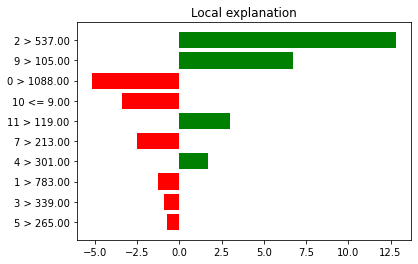

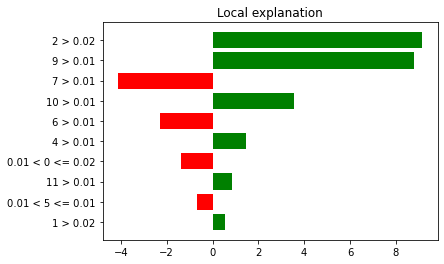

In [44]:
for exp in exp_list:
    new_observation = exp.data.iloc[[42]]
    exp.predict_surrogate(new_observation).plot()